https://gis.stackexchange.com/questions/350771/earth-engine-simplest-way-to-move-from-ee-image-to-array-for-use-in-sklearn

# Combine data from Google Earth Engine (GEE) and Geoscience Australia (GA)

GEE is a geospatial processing service. It has the option to be run through it's online JavaScript Code Editor, or can be accessed in python platforms such as Colab and Jupyter Notebooks. GEE provides access to many different datasets, including Sentinel 1, Landsat, PALSAR and MODIS (https://developers.google.com/earth-engine/datasets/catalog). 

To get started with GEE these links may help:
- User guides: https://developers.google.com/earth-engine/guides
- Get started using GEE with python: https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb

## Setup

#### Install GEE API

In [1]:
!pip install -U earthengine-api

     |████████████████████████████████| 147 kB 17.6 MB/s eta 0:00:01
  Using cached google_cloud_storage-1.32.0-py2.py3-none-any.whl (92 kB)
  Using cached google_api_python_client-1.12.5-py2.py3-none-any.whl (61 kB)
  Using cached google_auth_httplib2-0.0.4-py2.py3-none-any.whl (9.1 kB)
  Using cached httplib2-0.18.1-py3-none-any.whl (95 kB)
Processing /home/jovyan/.cache/pip/wheels/50/6c/00/2a8868de404e13a77667ff2c94e908e7cff9acd1d1dd307a48/httplib2shim-0.0.3-py2.py3-none-any.whl
  Using cached google_resumable_media-1.1.0-py2.py3-none-any.whl (75 kB)
  Using cached google_cloud_core-1.4.3-py2.py3-none-any.whl (27 kB)
  Using cached google_api_core-1.23.0-py2.py3-none-any.whl (91 kB)
  Using cached uritemplate-3.0.1-py2.py3-none-any.whl (15 kB)
  Using cached google_crc32c-1.0.0-cp36-cp36m-manylinux2010_x86_64.whl (39 kB)
  Using cached googleapis_common_protos-1.52.0-py2.py3-none-any.whl (100 kB)
  Created wheel for earthengine-api: filename=earthengine_api-0.1.242-py3-none-any.whl 

#### Authenticate

In [5]:
#ee.Authenticate()

In [6]:
ee.Initialize()

#### Import modules

In [3]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import sys
import folium
import datacube

sys.path.append("../Scripts")

In [4]:
dc = datacube.Datacube(app='gee')

## Load Imagery

### Define parameters 

In [7]:
# Define parameters

# Dates
# NOTE: GEE dates are inclusive and GA are exclusive on the end date
start = '2018-01-01'
end_ga = '2018-12-31'
end_gee = '2019-01-01'

# Set the central latitude and longitude
central_lat = -35.555439 
central_lon = 138.886889

In [8]:
# Set the buffer to load around the central coordinates
buffer = 0.05 # must be small for .sampleRectangle() to work

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

### Load GEE imagery

To load imagery from GEE generally you will need to:
- define an area of interest and pass to `filterBounds`
- define a time period of interest and pass to `filterDate`
- filter on metadata (commonly cloud cover)
- select bands of interest
- reproject

Imagery without a set projection will be called in WGS 94. Landsat pixels in GEE have ar 30m in length, compared to Landsat pixels in GA.

>**Note**: All options for how to manipulate GEE objects can be found here https://developers.google.com/earth-engine/apidocs

In [38]:
# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[study_area_lon[0], study_area_lat[0]],
    [study_area_lon[0], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[0]]]], None, False)

# Filter collection to get desired image
img = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")\
        .filterBounds(aoi)\
        .filterDate(start,end_gee)\
        .filter(ee.Filter.lt('CLOUD_COVER',5))\
        .select(['B4', 'B3', 'B2'])\
        .first()\
        .reproject('EPSG:3577',None,25)\

### Convert GEE image into a numpy array

The image returned to us is an ee.Image object. To integrate this with GA imagery, we need to convert the image object into an xarray.

In [39]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = img.sampleRectangle(region=aoi)

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B2') #B2
band_arr_b5 = band_arrs.get('B3') #B3
band_arr_b6 = band_arrs.get('B4') #B4

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())

# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
np_arr_b5 = np.expand_dims(np_arr_b5, 2)
np_arr_b6 = np.expand_dims(np_arr_b6, 2)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b6, np_arr_b5, np_arr_b4), 2)
print(rgb_img.shape)

(464, 387, 3)


### Display new numpy array

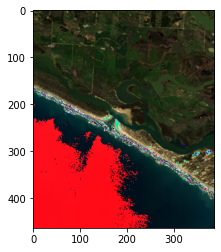

In [40]:
# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((rgb_img - 100)/3000)).astype('uint8')

plt.imshow(rgb_img_test)
plt.show()

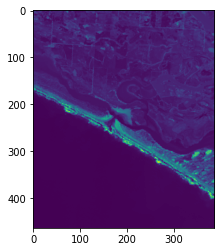

In [42]:
# Display a single band
plt.imshow(rgb_img[:,:,0])
plt.show()

### Load GA data

In [43]:
#Load all data in baseline period available from Near Real Time data
wofs = dc.load(
              product=['wofs_annual_summary'],
              x= study_area_lon,
              y= study_area_lat,
              time=(start, end_ga),
              output_crs='EPSG:3577',
              resolution=(-25,25),
              resampling='cubic'
)

In [44]:
wofs

<xarray.Dataset>
Dimensions:      (time: 1, x: 387, y: 464)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01
  * y            (y) float64 -3.895e+06 -3.895e+06 ... -3.906e+06 -3.906e+06
  * x            (x) float64 6.185e+05 6.185e+05 ... 6.281e+05 6.281e+05
    spatial_ref  int32 3577
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 ... 13 14 14 14 14 14 15 16
    count_clear  (time, y, x) int16 20 20 20 20 20 20 19 ... 14 14 14 14 15 16
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

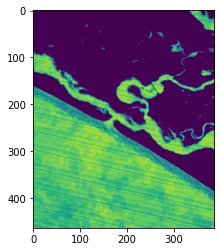

In [45]:
# Display wofs data
plt.imshow(np.array(wofs['count_wet'][0,:,:]))
plt.show()

Text(0.5, 1.0, 'GEE Satellite Imagery')

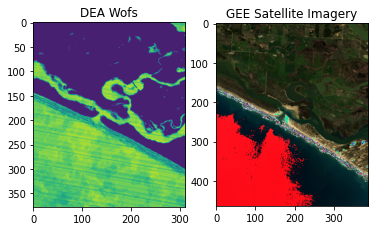

In [23]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.array(wofs['count_wet'][0,:,:]))
ax1.set_title('DEA Wofs')
ax2.imshow(rgb_img_test)
ax2.set_title('GEE Satellite Imagery')